In [15]:
#載入所需資料庫
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import backend as K
from vis.utils import utils
from keras import activations
from vis.input_modifiers import Jitter


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [16]:
#範例涵式
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
    
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
 
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

In [13]:
#設定圖片的長和寬150*150。
img_width, img_height = 150, 150
#設定train和validation的目錄。
train_data_dir = '/content/drive/MyDrive/data/train'
validation_data_dir = '/content/drive/MyDrive/data/validation'

#Building a Convolutional Neural Network
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
metrics=['accuracy'])

#指定training data和validation data為generator形式，開始訓練
history = model.fit(train_generator, epochs=7, validation_data=validation_generator, verbose=1)

#儲存訓練模型、訓練過程
model.save('/content/drive/MyDrive/data/model.h5')
save_history(history, '/content/drive/MyDrive/data/history.bin')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

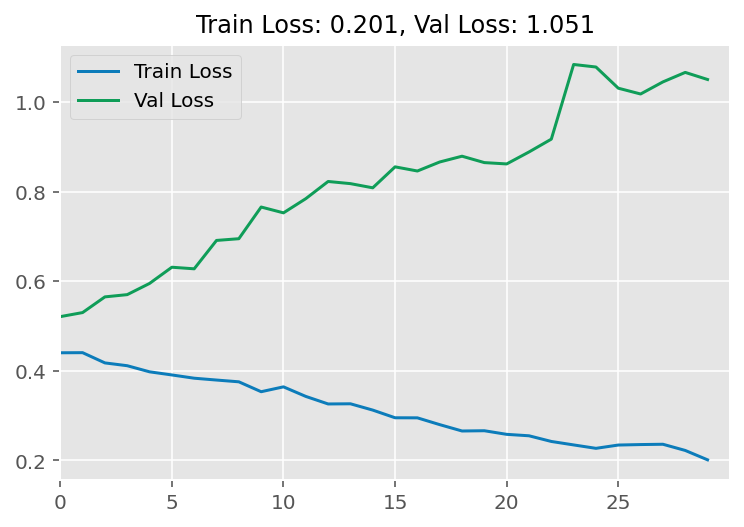

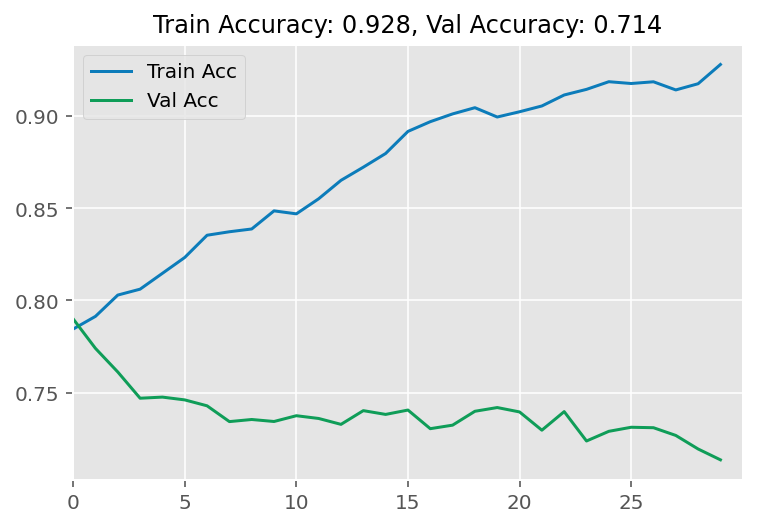

In [17]:
#載入預先儲存訓練過程
history = load_history('/content/drive/MyDrive/data/history.bin')
plot_compare(history)

#CNN總共的參數數量
model.summary()

#載入圖片，並利用先前儲存模型判斷圖片是貓還是狗
img_path = '/content/drive/MyDrive/data/test/cats/cat.155.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
predictions=model.predict(img_tensor) 
prediction=np.argmax(predictions,axis=1)
if prediction == 0:
    print("It is a cat!")
else:
    print("It is a dog!")


#顯示訓練出的model的Accuracy為何
for cat in os.listdir(path='/content/drive/MyDrive/data/test/cats'):
  img_path=os.path.join('/content/drive/MyDrive/data/test/cats', cat)
  img = image.load_img(img_path, target_size=(150, 150))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  predictions=model.predict(img_tensor) 
  prediction=np.argmax(predictions,axis=1)
  #prediction = model.predict_classes(img_tensor)
  if prediction ==0:
    correct_img=correct_img+1
    correct_img_cat=correct_img_cat+1
  total_img=total_img+1
  total_img_cat=total_img_cat+1



print("correct_predict_cat: "+str(correct_img_cat))
print("total_image_cat: "+str(total_img_cat))
print("prediction accuracy_cat: "+str(correct_img_cat/total_img_cat))



for dog in os.listdir(path='/content/drive/MyDrive/data/test/dogs'):
  img_path=os.path.join('/content/drive/MyDrive/data/test/dogs', dog)
  img = image.load_img(img_path, target_size=(150, 150))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  #test_tensors.append(img_tensor)
  #test_classes.append(1)
  predictions=model.predict(img_tensor) 
  prediction=np.argmax(predictions,axis=1)
  #prediction = model.predict_classes(img_tensor)
  if prediction ==1:
    correct_img=correct_img+1
    correct_img_dog=correct_img_dog+1
  total_img=total_img+1
  total_img_dog=total_img_dog+1

  

print("correct_predict_dog: "+str(correct_img_dog))
print("total_image_dog: "+str(total_img_dog))
print("prediction accuracy_dog: "+str(correct_img_dog/total_img_dog))



print("correct_predict: "+str(correct_img))
print("total_image: "+str(total_img))
print("prediction accuracy: "+str(correct_img/total_img))